# Topology of Graphs

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random

---

#### Challenge 1: Spanning trees

Write an algorithm showing that spanning tree exists for any connected multigraph.

---

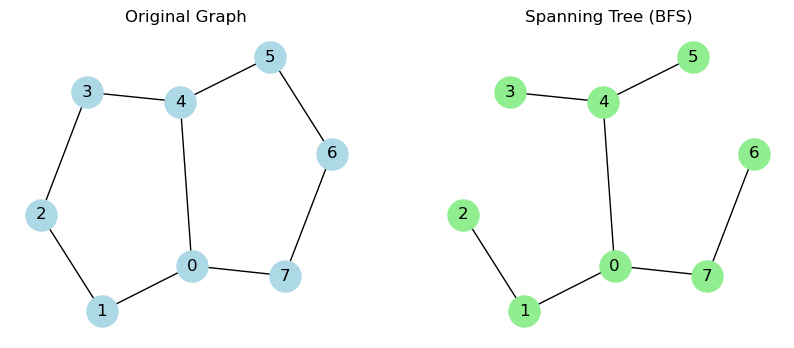

In [2]:
def spanning_tree_bfs(G, start=None):
    if start is None:
        start = list(G.nodes())[0]
    
    # Create an empty graph T with the same nodes as G
    T = nx.Graph()
    T.add_nodes_from(G.nodes())
    
    visited = set([start])
    queue = [start]
    
    while queue:
        v = queue.pop(0)  # Dequeue the front of the queue
        for w in G.neighbors(v):
            if w not in visited:
                visited.add(w)
                T.add_edge(v, w)
                queue.append(w)
    return T

# Create a simple connected graph (for example, a cycle graph with an extra chord)
G = nx.cycle_graph(8)
G.add_edge(0, 4)  # Adding an extra edge to make it a multigraph-like structure

# Compute the spanning tree using the BFS algorithm
T = spanning_tree_bfs(G)

# Set positions for a consistent layout
pos = nx.spring_layout(G, seed=42)

# Draw the original graph and the spanning tree
plt.figure(figsize=(10, 4))

plt.subplot(121)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
plt.title("Original Graph")

plt.subplot(122)
nx.draw(T, pos, with_labels=True, node_color='lightgreen', node_size=500)
plt.title("Spanning Tree (BFS)")
plt.show()

## Transformations

---
#### Challenge 2: Homeomorphisms of graphs

If you are familiar with the concept of a **homeomorphism** between topological spaces, prove the following:

*Two **multigraphs**, regarded as topological spaces, can be related by a sequence of edge subdivisions and their inverses (removing vertices of degree 2) if and only if there exists a homeomorphism between them.*

This equivalence justifies the terminology we are using.

---

**Answer:**  

Regard each graph \(G\) as a topological space built from vertices and edges. An **edge subdivision** corresponds to inserting a degree-2 vertex into the interior of an edge, which is topologically just subdividing that edge (an interval). This does not change the space up to homeomorphism. Conversely, **removing a degree-2 vertex** merges two subdivided intervals back into a single interval. Hence, performing or undoing these subdivisions corresponds precisely to local modifications that preserve the homeomorphism type of the resulting 1-dimensional space. Therefore, two multigraphs are homeomorphic (in the topological sense) if and only if one can be transformed into the other by a finite sequence of edge subdivisions and removals of degree-2 vertices.


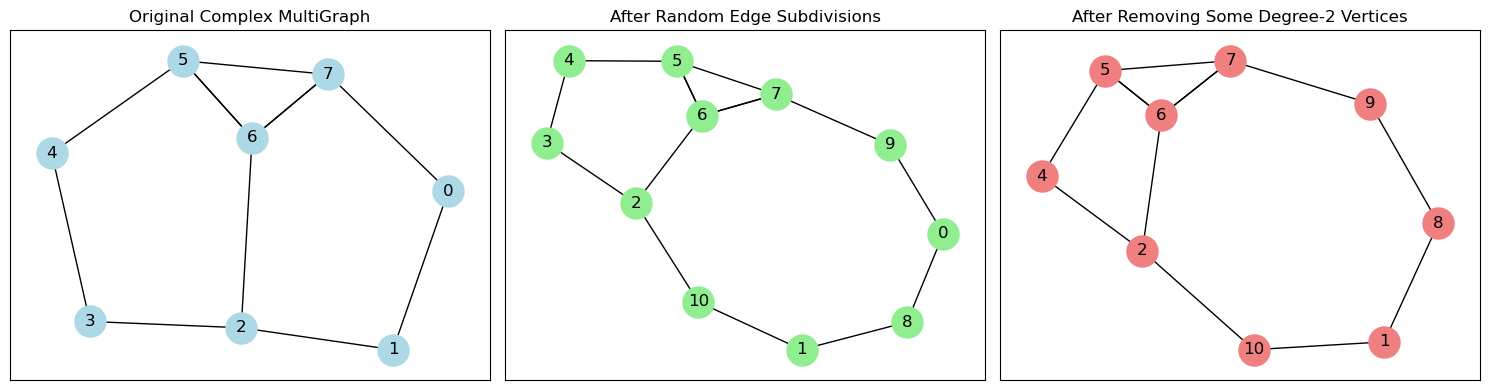

In [3]:
def subdivide_edge(G, u, v, new_vertex):
    """
    Subdivide edge (u, v) by inserting a new vertex 'new_vertex'.
    This splits (u, v) into two edges: (u, new_vertex) and (new_vertex, v).
    """
    if G.has_edge(u, v):
        # Remove the original edge
        G.remove_edge(u, v)
        # Add new vertex and the two new edges
        G.add_node(new_vertex)
        G.add_edge(u, new_vertex)
        G.add_edge(new_vertex, v)
    else:
        raise ValueError(f"Edge ({u}, {v}) does not exist in the graph.")

def remove_degree_2_vertex(G, w):
    """
    If vertex w is of degree 2, remove it and merge its two incident edges 
    into a single edge (the inverse of a subdivision).
    """
    if w not in G.nodes:
        raise ValueError(f"Vertex {w} does not exist.")
    if G.degree[w] != 2:
        raise ValueError(f"Vertex {w} is not of degree 2.")

    # Identify the two neighbors of w
    neighbors = list(G.neighbors(w))
    if len(neighbors) != 2:
        raise ValueError(f"Vertex {w} does not have exactly two neighbors.")
    u, v = neighbors

    # Remove w and connect its neighbors directly if they aren't already connected
    G.remove_node(w)
    if not G.has_edge(u, v):
        G.add_edge(u, v)

def random_complex_graph(num_nodes=8):
    """
    Construct a 'complex' graph with multiple cycles and possibly parallel edges
    (using MultiGraph). We will create a cycle, then add random chords or parallel edges.
    """
    G = nx.MultiGraph()
    G.add_nodes_from(range(num_nodes))
    
    # Start with a cycle for guaranteed connectivity
    for i in range(num_nodes):
        G.add_edge(i, (i+1) % num_nodes)
    
    # Add some random chords or parallel edges
    extra_edges = num_nodes // 2  # number of extra edges to try
    for _ in range(extra_edges):
        a, b = random.sample(range(num_nodes), 2)
        # Randomly add a parallel edge or a chord
        G.add_edge(a, b)
    
    return G

# 1. Build a more "complex" initial multigraph
random.seed(2023)  # for reproducibility
G_original = random_complex_graph(num_nodes=8)

# 2. Make a copy to perform subdivisions on random edges
G_subdiv = G_original.copy()

# Subdivide a few randomly chosen edges:
#   We'll try to subdivide 3 edges, if possible
edges_list = list(G_subdiv.edges())  # (u, v, key) in MultiGraph, but ignoring 'key' below
num_subdivisions = min(3, len(edges_list))  # cap to available edges
for i in range(num_subdivisions):
    # pick an edge to subdivide
    (u, v) = edges_list[i][:2]  # ignore the 'key' if present
    # create a new vertex label
    new_vertex = max(G_subdiv.nodes()) + 1  # or something unique
    subdivide_edge(G_subdiv, u, v, new_vertex)

# 3. Remove some degree-2 vertices from G_subdiv where possible
G_removed = G_subdiv.copy()

# We'll attempt to remove up to 2 random degree-2 vertices
vertices = list(G_removed.nodes())
random.shuffle(vertices)
removed_count = 0
for w in vertices:
    if w in G_removed and G_removed.degree[w] == 2:
        try:
            remove_degree_2_vertex(G_removed, w)
            removed_count += 1
            if removed_count >= 2:
                break
        except ValueError:
            pass  # maybe the degree changed unexpectedly

# --- Visualize the three graphs side-by-side ---

pos_original = nx.spring_layout(G_original, seed=10)
pos_subdiv = nx.spring_layout(G_subdiv, seed=10)
pos_removed = nx.spring_layout(G_removed, seed=10)

plt.figure(figsize=(15, 4))

# Plot original
plt.subplot(131)
nx.draw_networkx(
    G_original, pos_original, 
    with_labels=True, node_color='lightblue', node_size=500
)
plt.title("Original Complex MultiGraph")

# Plot after subdivisions
plt.subplot(132)
nx.draw_networkx(
    G_subdiv, pos_subdiv, 
    with_labels=True, node_color='lightgreen', node_size=500
)
plt.title("After Random Edge Subdivisions")

# Plot after removing some degree-2 vertices
plt.subplot(133)
nx.draw_networkx(
    G_removed, pos_removed, 
    with_labels=True, node_color='lightcoral', node_size=500
)
plt.title("After Removing Some Degree-2 Vertices")

plt.tight_layout()
plt.show()

**Explanation:**

1. We generate a 'complex' MultiGraph by:
   - Creating a cycle on 8 nodes (guarantees at least one cycle).
   - Adding some extra random chords or parallel edges, making it non-trivial.

2. We make a copy (G_subdiv) and subdivide a few edges by inserting new degree-2 vertices.
   Each subdivision corresponds to splitting one edge into two edges.

3. We make another copy (G_removed) and remove a couple of degree-2 vertices (if they exist).
   This step merges their two incident edges back into one edge.

Both the subdivision and removal of degree-2 vertices are topological operations
that do not change the 1-dimensional 'homeomorphism type' of the underlying space.
Hence G_original, G_subdiv, and G_removed are all homeomorphic as topological graphs.

### Transformation 2: Contractions

---

#### Challenge 3: Contracting trees

Write an algorithm that generates a sequence of edge contractions that transforms any tree into a single point. This algorithm demonstrates that all trees are contractible.

---

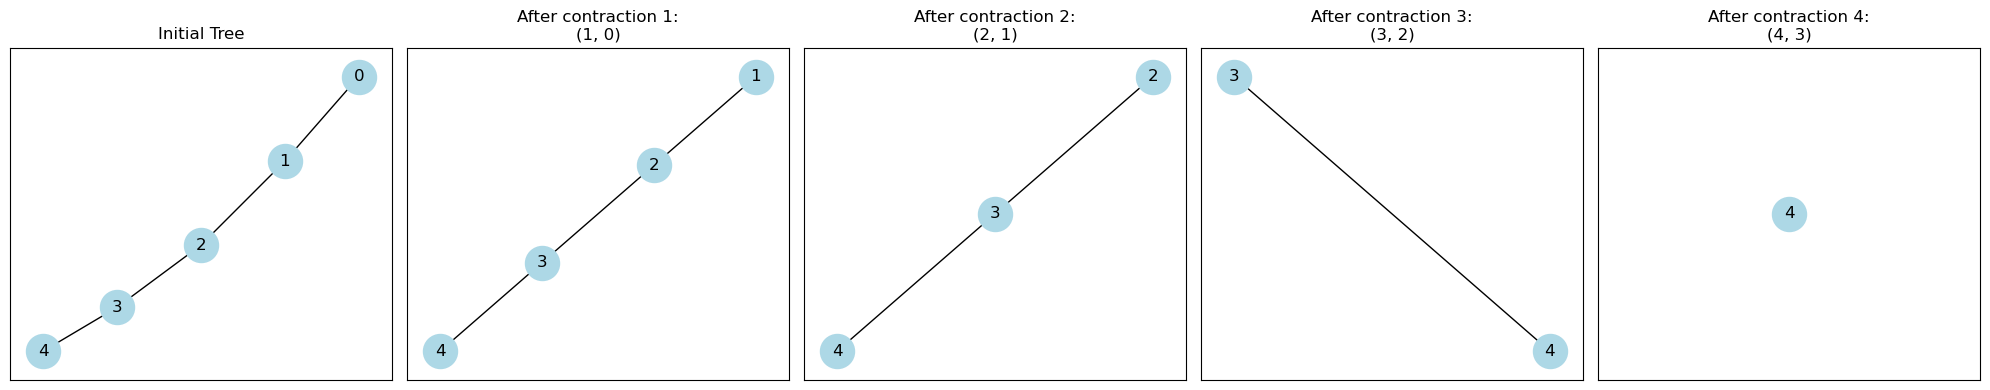


Contractions sequence (parent, leaf) in order:
Step 1: contract (1, 0)
Step 2: contract (2, 1)
Step 3: contract (3, 2)
Step 4: contract (4, 3)


In [4]:
def contract_tree_show_last_step(T):
    """
    Given a tree T (connected, acyclic graph), this function repeatedly contracts
    edges until only a single vertex remains, plotting each step AND finally
    showing the last contracted graph (a single point).
    
    The function returns the contraction sequence but also includes the final
    (single-node) state in its plots.
    """
    if not nx.is_tree(T):
        raise ValueError("Input graph must be a tree (connected and acyclic).")

    # Work on a copy to avoid modifying the original
    T = T.copy()
    n = T.number_of_nodes()
    if n == 1:
        print("The tree has only one node—nothing to contract or show in steps.")
        return []

    # We will have (n-1) contractions, but we'll create n subplots:
    #   1) Subplot 1: the initial tree
    #   2) Subplots 2..n: the state of the graph after each of the (n-1) contractions
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    # If there's only one row, wrap axes in a list for consistency
    if n == 1:
        axes = [axes]

    # Plot the initial tree in the first subplot
    pos = nx.spring_layout(T, seed=42)
    ax = axes[0]
    nx.draw_networkx(T, pos, ax=ax, with_labels=True, node_color='lightblue', node_size=600)
    ax.set_title("Initial Tree")

    contractions = []
    # Perform edge contractions step-by-step
    for step in range(n - 1):
        # Find a leaf (degree 1 node)
        leaf_candidates = [node for node in T.nodes if T.degree[node] == 1]
        leaf = leaf_candidates[0]  # pick the first leaf
        neighbors = list(T.neighbors(leaf))
        parent = neighbors[0]  # the unique neighbor of the leaf

        # Record which edge is contracted
        contractions.append((parent, leaf))

        # Contract (parent, leaf): remove the leaf, link its neighbors to 'parent'
        for nbr in list(T.neighbors(leaf)):
            if nbr != parent:
                T.add_edge(parent, nbr)
        T.remove_node(leaf)

        # Plot the resulting graph
        ax_next = axes[step + 1]
        pos = nx.spring_layout(T, seed=42)
        nx.draw_networkx(T, pos, ax=ax_next, with_labels=True,
                         node_color='lightblue', node_size=600)
        ax_next.set_title(f"After contraction {step+1}:\n({parent}, {leaf})")

    plt.tight_layout()
    plt.show()

    return contractions

# A small tree: path on 5 nodes
path_tree = nx.path_graph(5)  # nodes: 0 - 1 - 2 - 3 - 4
steps = contract_tree_show_last_step(path_tree)

print("\nContractions sequence (parent, leaf) in order:")
for i, (p, l) in enumerate(steps, start=1):
    print(f"Step {i}: contract ({p}, {l})")


---

#### Challenge 4: Homeomorphic implies homotopy equivalent

Show, using the definitions of this notebook, that if two multigraphs have the same homeomorphism type then they have the same homotopy type.

---

**Answer:** 

Two multigraphs \(G\) and \(H\) are said to be *homeomorphic* if one can be obtained from the other by subdividing edges or removing degree-2 vertices. Meanwhile, two multigraphs share the same *homotopy type* if one can be obtained from the other by contracting edges or “uncontracting” them.

1. **Subdivisions and degree-2 removals preserve homotopy type**  
   - Subdividing an edge (inserting a degree-2 vertex) does *not* affect how cycles or connectivity can be contracted away.  
   - Conversely, removing a degree-2 vertex also does *not* change which edges can be contracted later.  
   - In other words, these operations leave the “shape” of the graph unchanged under edge contractions.

2. **Key idea**  
   If \(G\) and \(H\) are homeomorphic, there is a finite sequence of subdivisions / degree-2 removals transforming \(G\) into \(H\). But *each* step in that sequence preserves the *ability* to contract edges in the same essential ways. Consequently, if you can contract \(G\) down to (say) a single point, then you can perform the same (or corresponding) contractions after each subdivision / degree-2 removal, ultimately contracting \(H\) to a point as well. Hence \(G\) and \(H\) must be homotopy equivalent.

Therefore, sharing the same *homeomorphism* type implies they share the same *homotopy* type.


## Euler characteristic

### Examples

#### Example 2: Disjoint unions

The **disjoint union** of two multigraphs $G = (V, E)$ and $G' = (V', E')$ is a new multigraph $G \sqcup G' = (V'', E'')$ with $V'' = V \sqcup V'$ and $E'' = E \sqcup E'$.

It is immediate to see that
$$\chi(G \sqcup G') = \chi(G) + \chi(G').$$
Therefore, the Euler characteristic of a multigraph is equal to the sum of the Euler characteristic of its connected components.

Let us verify the following closed form formula for the Euler characteristic of the disjoint union of the first $n$ complete graphs:

$$g(n) = -n \cdot (n + 1) \cdot \left( \frac{n - 4}{6} \right).$$


---
#### Challenge 5

Prove the correctness of the proposed formula.

---

**Brief Proof of the Formula**

We want to show that the Euler characteristic $\chi$ of the disjoint union of the complete graphs
$$
K_0, K_1, \dots, K_n
$$
is given by
$$
g(n) \;=\; -\,n \,(n+1)\,\frac{n-4}{6}.
$$

1. **Recall $\chi(K_k)$**  
   - A complete graph $K_k$ has $k$ vertices and $\tfrac{k(k-1)}{2}$ edges.  
   - Hence its Euler characteristic is
     $$
     \chi(K_k) \;=\; k \;-\; \frac{k(k-1)}{2}.
     $$
   - Note that $K_0$ (no vertices, no edges) has $\chi(K_0) = 0$.

2. **Sum Over $K_0, \dots, K_n$**  
   By **disjoint union**, the total Euler characteristic is the sum of each $\chi(K_k)$:
   $$
   \chi\Bigl(\bigsqcup_{k=0}^n K_k\Bigr)
   \;=\;
   \sum_{k=0}^n \chi(K_k)
   \;=\;
   \chi(K_0) \;+\;
   \sum_{k=1}^n 
   \Bigl(k \;-\; \tfrac{k(k-1)}{2}\Bigr).
   $$
   Since $\chi(K_0) = 0$, we focus on
   $$
   \sum_{k=1}^n 
   \Bigl(k \;-\; \tfrac{k(k-1)}{2}\Bigr)
   \;=\;
   \sum_{k=1}^n k
   \;-\;
   \tfrac12 \sum_{k=1}^n k(k-1).
   $$

3. **Compute Each Part**  
   - $\displaystyle \sum_{k=1}^n k = \frac{n(n+1)}{2}.$  
   - $\displaystyle \sum_{k=1}^n k(k-1) = \sum_{k=1}^n \bigl(k^2 - k\bigr) 
       = \sum_{k=1}^n k^2 - \sum_{k=1}^n k
       = \frac{n(n+1)(2n+1)}{6} - \frac{n(n+1)}{2}
       = \frac{n(n+1)(n-1)}{3}.$  
   Therefore,
   $$
   \tfrac12 \sum_{k=1}^n k(k-1)
   \;=\;
   \frac{n(n+1)(n-1)}{6}.
   $$

4. **Combine**  
   Putting it all together:
   $$
   \sum_{k=1}^n \Bigl(k - \tfrac{k(k-1)}{2}\Bigr)
   \;=\;
   \frac{n(n+1)}{2}
   \;-\;
   \frac{n(n+1)(n-1)}{6}
   \;=\;
   \frac{n(n+1)}{6} \bigl(3 - (n-1)\bigr)
   \;=\;
   \frac{n(n+1)(4 - n)}{6}.
   $$
   Equivalently, that can be written as
   $$
   -\,n\,(n+1)\,\frac{n-4}{6},
   $$
   matching the proposed formula $g(n)$.  

Hence,
$$
\chi\Bigl(K_0 \sqcup K_1 \sqcup \dots \sqcup K_n\Bigr)
\;=\;
g(n)
\;=\;
-\,n\,(n+1)\,\frac{n-4}{6}.
$$
This completes the proof.


### Example 3: Erdős-Rényi graphs

---

#### Challenge 6

The quantity $\beta_0(n, p)$, representing the number of connected components of an Erdős-Rényi graph $G(n, p)$, also exhibits stable behavior in two distinct regimes of $p$ as $n \to \infty$.

Prove the following:

- If $p < \frac{\log n}{n}$, then $\beta_0(n, p) \to \infty$ as $n \to \infty$.
- If $p > \frac{\log n}{n}$, then $\beta_0(n, p) \to 1$ as $n \to \infty$.

---

**Answer:**

1. **Model Setup**  
   In the Erdős–Rényi model $G(n,p)$, each of the $\binom{n}{2}$ possible edges appears independently with probability $p$. We analyze the **number of connected components**, denoted by $\beta_0(n, p)$, in two regimes of $p$ relative to $\frac{\log n}{n}$.

2. **Case 1: $p < \frac{\log n}{n}$**  
   - **Heuristic**: When $p$ is below $\frac{\log n}{n}$, the graph $G(n,p)$ typically has many isolated vertices or tiny components.
   - **Reason**: The probability that a fixed vertex $v$ is isolated (no edges) is 
     $$
     (1 - p)^{\,n-1} \;\approx\; \exp\bigl[-\,p(n-1)\bigr].
     $$
     For $p < \frac{\log n}{n}$, we have $p(n-1) < \log n$, so 
     $$
     \exp\bigl[-\,p(n-1)\bigr] \;>\; \exp(-\log n) \;=\; \frac{1}{n}.
     $$
     Thus, the **expected number** of isolated vertices is at least 
     $$
     n \times \frac{1}{n} \;=\; 1
     $$
     (and in fact, often grows unboundedly for $p \ll \frac{\log n}{n}$). By a concentration argument, we typically get **many** isolated vertices as $n \to \infty$. Having many isolated vertices implies having **many connected components** overall. Hence,
     $$
     \beta_0(n, p) \;\to\; \infty
     \quad\text{as } n\to\infty \quad (\text{if } p < \tfrac{\log n}{n}).
     $$

3. **Case 2: $p > \frac{\log n}{n}$**  
   - **Heuristic**: When $p$ is above $\frac{\log n}{n}$, the graph $G(n,p)$ is almost surely connected.
   - **Reason**: A fundamental theorem in random graph theory states that if $p > \tfrac{\log n}{n}$, then with high probability the largest component “swallows” almost every node, leaving (with vanishing probability) only a few small components. In fact, once $p$ exceeds $\frac{\log n}{n}$, the probability that there is **even one** isolated vertex goes to zero. Consequently, one finds that
     $$
     \beta_0(n, p) \;\to\; 1
     \quad\text{as } n\to\infty \quad (\text{if } p > \tfrac{\log n}{n}).
     $$

4. **Conclusion**  
   These two classical threshold results show that $\beta_0(n, p)$ (the number of connected components in $G(n,p)$) **explodes** to infinity below $p < \frac{\log n}{n}$ and **collapses** to 1 above $p > \frac{\log n}{n}$. In short:
   - **Subcritical ($p < \log n / n$):** many components, $\beta_0(n,p) \to \infty.$
   - **Supercritical ($p > \log n / n$):** the graph is almost surely connected, $\beta_0(n,p) \to 1.$


### Minimal model

---

#### Challenge 7

Construct two graphs with the same number of connected components and Euler characteristic which do not have the same homotopy type.

---

In [5]:
import itertools

def all_simple_graphs_on_n_vertices(n):
    """
    Generator that yields all simple (undirected, no parallel edges, no self-loops)
    NetworkX graphs on n labeled vertices: 0, 1, ..., n-1.
    """
    nodes = range(n)
    edges = list(itertools.combinations(nodes, 2))  # all possible edges
    # Each edge can be "in" or "out", so 2^(len(edges)) possibilities
    for subset_mask in range(1 << len(edges)):
        G = nx.Graph()
        G.add_nodes_from(nodes)
        for i, e in enumerate(edges):
            if (subset_mask & (1 << i)) != 0:
                G.add_edge(*e)
        yield G

def beta_0_and_chi(G):
    """
    Returns (beta0, chi) for a simple graph G.
    - beta0 = number of connected components
    - chi = |V| - |E| (Euler characteristic)
    """
    c = nx.number_connected_components(G)
    v = G.number_of_nodes()
    e = G.number_of_edges()
    return c, (v - e)

def beta_1(G):
    """
    Returns beta1 for a simple graph G.
    Recall beta1 = e - (v - c), for each connected component sum up (edges - (nodes-1)).
    But for the entire graph: beta1 = E - (V - C).
    """
    c = nx.number_connected_components(G)
    v = G.number_of_nodes()
    e = G.number_of_edges()
    return e - (v - c)

def find_same_beta0_chi_diff_homotopy(max_n=5):
    """
    Searches over all simple graphs up to n = max_n vertices to see if there exist
    two distinct graphs with:
       - same beta0 (number of connected components)
       - same chi (Euler characteristic)
       - but different beta1  (which would imply different homotopy types in 1D)
    Returns a pair (G1, G2) if found, else None.
    """
    # Key: (beta0, chi), Value: dict mapping beta1 -> list of graphs
    # We store multiple graphs that share the same (beta0, chi, beta1).
    # If we ever find two graphs that share (beta0, chi) but differ in beta1,
    # that's the "counterexample" we want.
    data = {}

    for n in range(1, max_n+1):
        for G in all_simple_graphs_on_n_vertices(n):
            c, x = beta_0_and_chi(G)   # c = beta0, x = chi
            b1 = beta_1(G)
            data.setdefault((c, x), {})
            data[(c, x)].setdefault(b1, []).append(G)
            # Check if there's more than one distinct beta1 for the same (c, x)
            if len(data[(c, x)]) > 1:
                # That means we found at least two distinct beta1 values
                # for the same (beta0, chi). Let's extract them as a "counterexample".
                b1_keys = sorted(data[(c, x)].keys())
                if len(b1_keys) > 1:
                    # We'll pick the first two distinct b1 values
                    b1_a = b1_keys[0]
                    b1_b = b1_keys[1]
                    G1 = data[(c, x)][b1_a][0]
                    G2 = data[(c, x)][b1_b][0]
                    return G1, G2

    # If we exhaust everything and find no example
    return None

result = find_same_beta0_chi_diff_homotopy(max_n=5)
if result is None:
    print("No two simple graphs found (up to 5 vertices) with the same (beta0, chi) but different beta1.")
    print("Hence, no counterexample exists in 1D graph topology.")
else:
    G1, G2 = result
    print("Counterexample found! Two distinct graphs share the same (beta0, chi) but differ in beta1.")
    print(f"Number of nodes in G1: {G1.number_of_nodes()}, edges: {G1.number_of_edges()}")
    print(f"  beta0(G1) = {nx.number_connected_components(G1)}, chi(G1) = {G1.number_of_nodes()-G1.number_of_edges()}, beta1(G1) = {beta_1(G1)}")
    print(f"Number of nodes in G2: {G2.number_of_nodes()}, edges: {G2.number_of_edges()}")
    print(f"  beta0(G2) = {nx.number_connected_components(G2)}, chi(G2) = {G2.number_of_nodes()-G2.number_of_edges()}, beta1(G2) = {beta_1(G2)}")


No two simple graphs found (up to 5 vertices) with the same (beta0, chi) but different beta1.
Hence, no counterexample exists in 1D graph topology.
